In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-


# Machine Learning

## Session 14a

### OpenVINO

<img src='../../prasami_images/prasami_color_tutorials_small.png' style = 'width:400px;' alt="By Pramod Sharma : pramod.sharma@prasami.com" align="left"/>

In [2]:
import sys
import os

import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2

from openvino.runtime import Core

from pathlib import Path

import tensorflow as tf
from IPython.display import Markdown

sys.path.append("/home/dhpcsap/Desktop/AI/day_05/day_13/utils")
from notebook_utils import segmentation_map_to_image

2024-06-18 19:49:20.265039: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-18 19:49:20.314751: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-18 19:49:20.314788: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-18 19:49:20.315906: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-06-18 19:49:20.323283: I tensorflow/core/platform/cpu_feature_guar

In [12]:
# Some Basic Parameters for housekeeping

# set location of input files:
inpDir = os.path.join('..', '..', 'input')

# set location of inputs for this module
moduleDir = 'machine_learning'

# set location of output files
outDir = os.path.join('..', 'output')

# set location of model files
modelDir = os.path.join('.', 'vino_model')

# define and set random state 
RANDOM_STATE = 24
np.random.seed(RANDOM_STATE) # Set Random Seed for reproducible  results

# parameters for Matplotlib
params = {'legend.fontsize': 'large',
          'figure.figsize': (15, 9),
          'axes.labelsize': 'large',
          'axes.titlesize':'x-large',
          'xtick.labelsize':'x-large',
          'ytick.labelsize':'large',
          'savefig.dpi': 75,
          'image.interpolation': 'none',
          'savefig.bbox' : 'tight',
          'lines.linewidth' : 1,
          'legend.numpoints' : 1
         }

CMAP = plt.cm.brg
plt.rcParams.update(params);
plt.set_cmap(CMAP);

plt.style.use('bmh')

TEST_SIZE = 0.2

<Figure size 1500x900 with 0 Axes>

OpenVINO is an open-source toolkit for optimizing and deploying deep learning models. It provides boosted deep learning performance for vision, audio, and language models from popular frameworks like TensorFlow, PyTorch, and more. 

<a href='https://docs.openvino.ai/latest/home.html' /><img src='../../images/ov_chart.png' width='600px' alt="Open VINO Chart"/>


OpenVINO enables you to optimize a deep learning model from almost any framework and deploy it with best-in-class performance on a range of Intel processors and other hardware platforms.

A typical workflow with OpenVINO is shown below.

<img src='../../images/openVINO_fig2.png' width='600' alt="OpenVINO Workflow"/>

OpenVINO Runtime automatically optimizes deep learning pipelines using aggressive graph fusion, memory reuse, load balancing, and inferencing parallelism across CPU, GPU, VPU, and more. You can integrate and offload to accelerators additional operations for pre- and post-processing to reduce end-to-end latency and improve throughput.

Boost your model’s speed even further with quantization and other state-of-the-art compression techniques available in OpenVINO’s Post-Training Optimization Tool and Neural Network Compression Framework. These techniques also reduce your model size and memory requirements, allowing it to be deployed on resource-constrained edge hardware.



### Local Inferencing & Model Serving

You can either link directly with OpenVINO Runtime to run inference locally or use OpenVINO Model Serving to serve model inference from separate server or within Kubernetes environment

### Improved Application Portability

Write an application once, deploy it anywhere, achieving maximum performance from hardware. Automatic device discovery allows for superior deployment flexibility. OpenVINO Runtime supports Linux, Windows and MacOS and provides Python, C++ and C API. Use your preferred language and OS.

### Minimal External Dependencies

Designed with minimal external dependencies reduces the application footprint, simplifying installation and dependency management. Popular package managers enable application dependencies to be easily installed and upgraded. Custom compilation for your specific model(s) further reduces final binary size.



### Enhanced App Start-Up Time

In applications where fast start-up is required, OpenVINO significantly reduces first-inference latency by using the CPU for initial inference and then switching to GPU or VPU once the model has been compiled and loaded to memory. Compiled models are cached to further improving start-up time.


In [13]:
# Instantiate the Inference Engine
ie = Core()
ie.available_devices

['CPU']

In [14]:
devices = ie.available_devices
for device in devices:
    device_name = ie.get_property(device, 'FULL_DEVICE_NAME')
    print(f"{device}: {device_name}")

CPU: Intel(R) Xeon(R) Silver 4208 CPU @ 2.10GHz


In [15]:
device = devices[0]
device

'CPU'

In [16]:
model = ie.read_model(model=os.path.join(modelDir, 'v3-small_224_1.0_float.xml'))
compiled_model = ie.compile_model(model=model, device_name = device)

output_layer = compiled_model.output(0)
output_layer

<ConstOutput: names[MobilenetV3/Predictions/Softmax:0] shape[1,1001] type: f32>

In [17]:
compiled_model.input(0)

<ConstOutput: names[input:0] shape[1,224,224,3] type: f32>

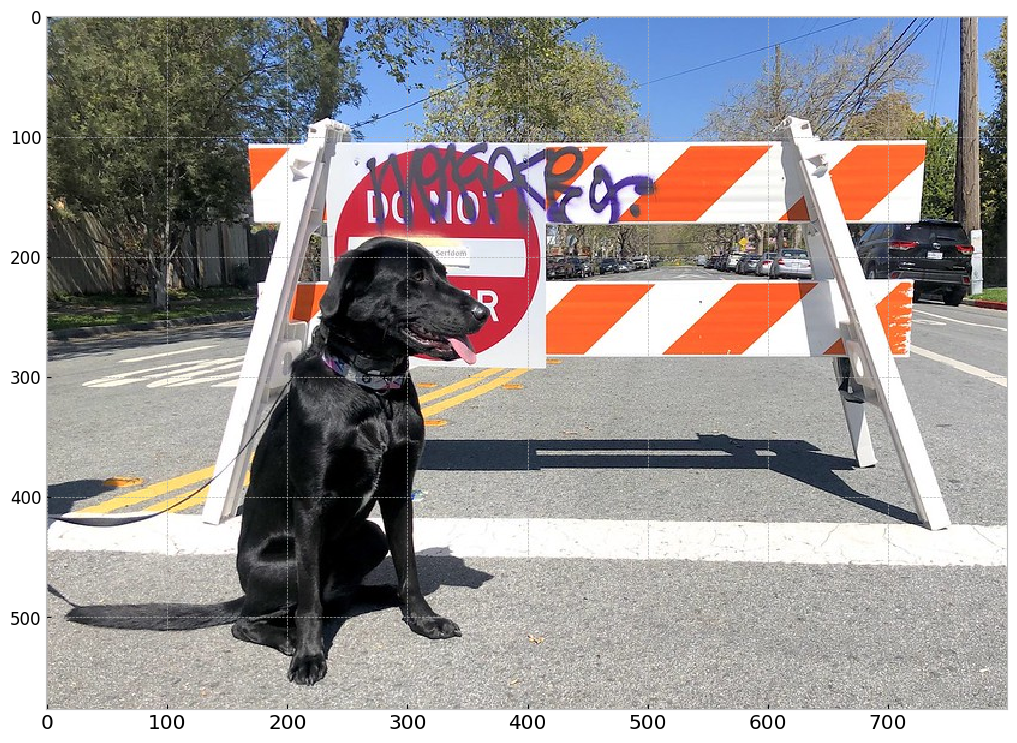

In [19]:
# The MobileNet model expects images in RGB format.
image = cv2.cvtColor(cv2.imread(filename=os.path.join(inpDir,'/home/dhpcsap/Desktop/AI/day_05/day_13/data/image/coco.jpg')),
                     code=cv2.COLOR_BGR2RGB)

# Resize to MobileNet image shape.
input_image = cv2.resize(src=image, dsize=(224, 224))

# Reshape to model input shape.
input_image = np.expand_dims(input_image, 0)
plt.imshow(image)
plt.show()


## Inference

In [20]:
result_infer = compiled_model([input_image])[output_layer]
result_index = np.argmax(result_infer)

In [22]:
imagenetClassesPath = os.path.join(inpDir,'/home/dhpcsap/Desktop/AI/day_05/day_13/data/datasets/imagenet/imagenet_2012.txt')

In [23]:
# Convert the inference result to a class name.
imagenet_classes = open(imagenetClassesPath).read().splitlines()

# The model description states that for this model, class 0 is a background.
# Therefore, a background must be added at the beginning of imagenet_classes.
imagenet_classes = ['background'] + imagenet_classes

imagenet_classes[result_index]

'n02099267 flat-coated retriever'

## Image Segmentation

A very basic introduction to using segmentation models with OpenVINO™.

In this tutorial, a pre-trained [road-segmentation-adas-0001](https://docs.openvino.ai/latest/omz_models_model_road_segmentation_adas_0001.html) model from the [Open Model Zoo](https://github.com/openvinotoolkit/open_model_zoo/) is used. ADAS stands for Advanced Driver Assistance Services. The model recognizes four classes: background, road, curb and mark.

In [24]:
ie = Core()

model = ie.read_model(model=os.path.join(modelDir, 'road-segmentation-adas-0001.xml'))
compiled_model = ie.compile_model(model=model)

input_layer_ir = compiled_model.input(0)
output_layer_ir = compiled_model.output(0)

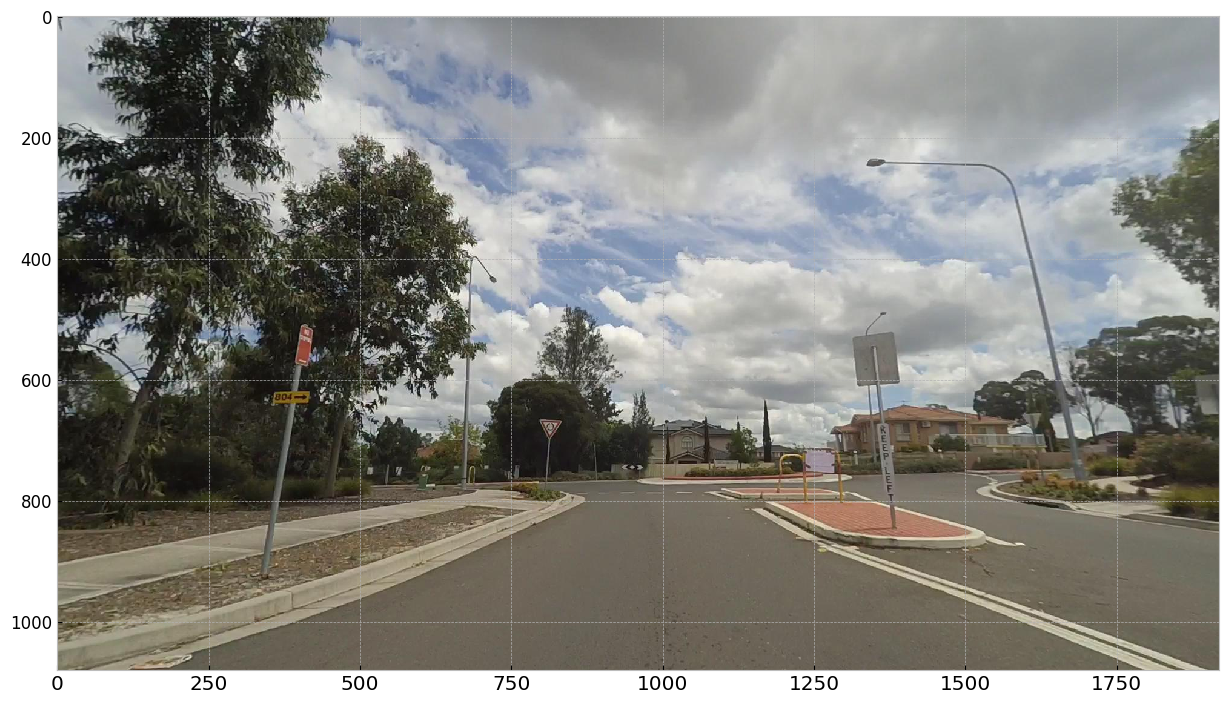

In [26]:
# The segmentation network expects images in BGR format.
image = cv2.imread(filename=os.path.join(inpDir,"/home/dhpcsap/Desktop/AI/day_05/day_13/data/image/empty_road_mapillary.jpg"))

rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image_h, image_w, _ = image.shape

# N,C,H,W = batch size, number of channels, height, width.
N, C, H, W = input_layer_ir.shape

# OpenCV resize expects the destination size as (width, height).
resized_image = cv2.resize(image, (W, H))

# Reshape to the network input shape.
input_image = np.expand_dims(
    resized_image.transpose(2, 0, 1), 0
)  
plt.imshow(rgb_image);

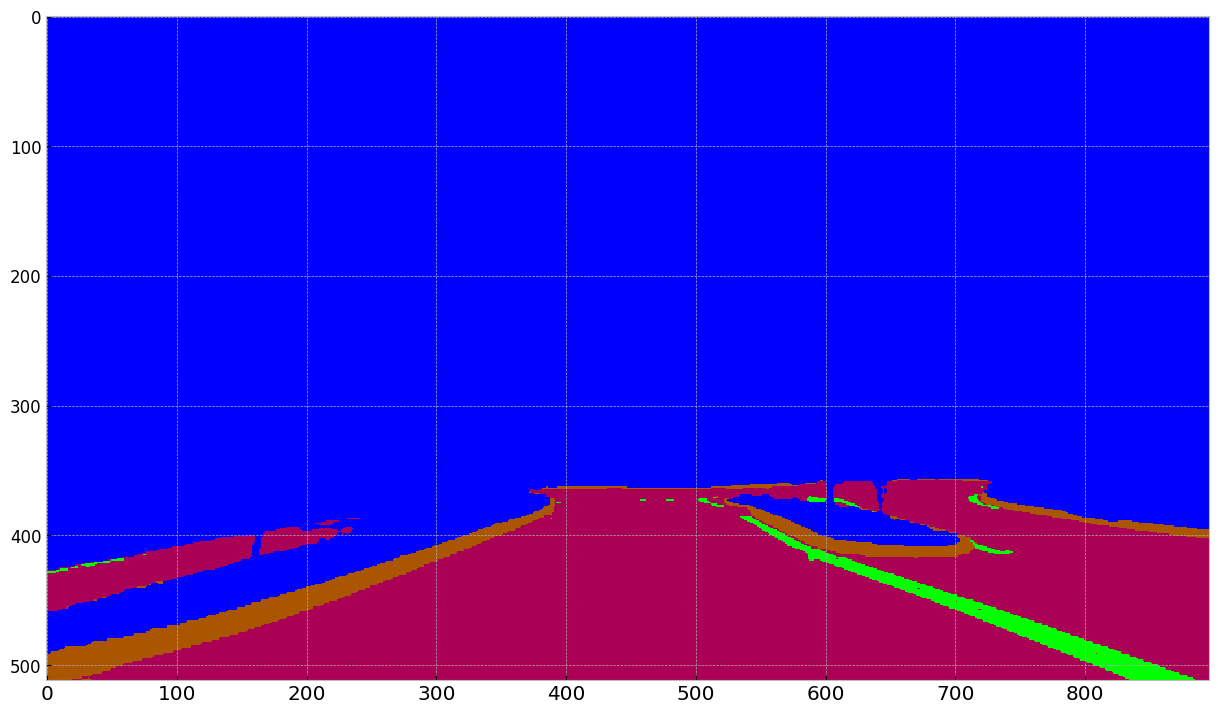

In [27]:
# Run the inference.
result = compiled_model([input_image])[output_layer_ir]

# Prepare data for visualization.
segmentation_mask = np.argmax(result, axis=1)
plt.imshow(segmentation_mask.transpose(1, 2, 0))

In [28]:
# Define colormap, each color represents a class.
colormap = np.array([[68, 1, 84], [48, 103, 141], [53, 183, 120], [199, 216, 52]])

# Define the transparency of the segmentation mask on the photo.
alpha = 0.3

# Use function from notebook_utils.py to transform mask to an RGB image.
mask = segmentation_map_to_image(segmentation_mask, colormap)
resized_mask = cv2.resize(mask, (image_w, image_h))

# Create an image with mask.
image_with_mask = cv2.addWeighted(resized_mask, alpha, rgb_image, 1 - alpha, 0)

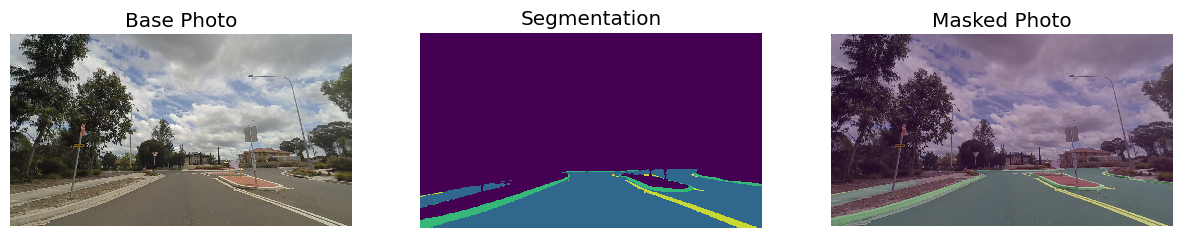

In [29]:
# Define titles with images.
data = {"Base Photo": rgb_image, "Segmentation": mask, "Masked Photo": image_with_mask}

# Create a subplot to visualize images.
fig, axs = plt.subplots(1, len(data.items()), figsize=(15, 10))

# Fill the subplot.
for ax, (name, image) in zip(axs, data.items()):
    ax.axis('off')
    ax.set_title(name)
    ax.imshow(image)

# Display an image.
plt.show(fig)

In [30]:
# The paths of the source and converted models.
model_dir = Path(modelDir)
model_dir.mkdir(exist_ok=True)

model_path = Path(os.path.join(modelDir, 'v3-small_224_1.0_float' ) )

ir_path = Path(os.path.join(modelDir, 'v3-small_224_1.0_float.xml' ) )

In [31]:
model = tf.keras.applications.MobileNetV3Small()
model.save(model_path)

2024-06-18 19:57:02.441616: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:274] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


10734624/10734624 [==============================] - 2s 0us/step
INFO:tensorflow:Assets written to: vino_model/v3-small_224_1.0_float/assets


INFO:tensorflow:Assets written to: vino_model/v3-small_224_1.0_float/assets


## Convert a Model to OpenVINO IR Format

### Convert a TensorFlow Model to OpenVINO IR Format

Use Model Optimizer to convert a TensorFlow model to OpenVINO IR with `FP16` precision. The models are saved to the current directory. Add mean values to the model and scale the output with the standard deviation with `--scale_values`. With these options, it is not necessary to normalize input data before propagating it through the network. The original model expects input images in `RGB` format. The converted model also expects images in `RGB` format. If you want the converted model to work with `BGR` images, use the `--reverse-input-channels` option. For more information about Model Optimizer, including a description of the command-line options, see the [Model Optimizer Developer Guide](https://docs.openvino.ai/latest/openvino_docs_MO_DG_Deep_Learning_Model_Optimizer_DevGuide.html). For information about the model, including input shape, expected color order and mean values, refer to the [model documentation](https://docs.openvino.ai/latest/omz_models_model_mobilenet_v3_small_1_0_224_tf.html).

First construct the command for Model Optimizer, and then execute this command in the notebook by prepending the command with an `!`. There may be some errors or warnings in the output. When model optimization is successful, the last lines of the output will include `[ SUCCESS ] Generated IR version 11 model.`

In [32]:
# Construct the command for Model Optimizer.
mo_command = f"""mo
                 --saved_model_dir "{model_path}"
                 --input_shape "[1,224,224,3]"
                 --model_name "{model_path.name}"
                 --compress_to_fp16
                 --output_dir "{model_path.parent}"
                 """
mo_command = " ".join(mo_command.split())
print("Model Optimizer command to convert TensorFlow to OpenVINO:")
display(Markdown(f"`{mo_command}`"))

Model Optimizer command to convert TensorFlow to OpenVINO:


`mo --saved_model_dir "vino_model/v3-small_224_1.0_float" --input_shape "[1,224,224,3]" --model_name "v3-small_224_1.0_float" --compress_to_fp16 --output_dir "vino_model"`

In [33]:
# Run Model Optimizer if the IR model file does not exist
if not ir_path.exists():
    print("Exporting TensorFlow model to IR... This may take a few minutes.")
    ! $mo_command
else:
    print(f"IR model {ir_path} already exists.")

IR model vino_model/v3-small_224_1.0_float.xml already exists.


In [ ]:
## Test Inference on the Converted Model

In [34]:
ie = Core()
model = ie.read_model(ir_path)
compiled_model = ie.compile_model(model=model, device_name="CPU")

In [35]:
input_key = compiled_model.input(0)
output_key = compiled_model.output(0)
network_input_shape = input_key.shape 

In [36]:
input_key

<ConstOutput: names[input:0] shape[1,224,224,3] type: f32>

In [37]:
output_key

<ConstOutput: names[MobilenetV3/Predictions/Softmax:0] shape[1,1001] type: f32>

In [38]:
network_input_shape

<Shape: [1,224,224,3]>

### Load an Image

Load an image, resize it, and convert it to the input shape of the network.

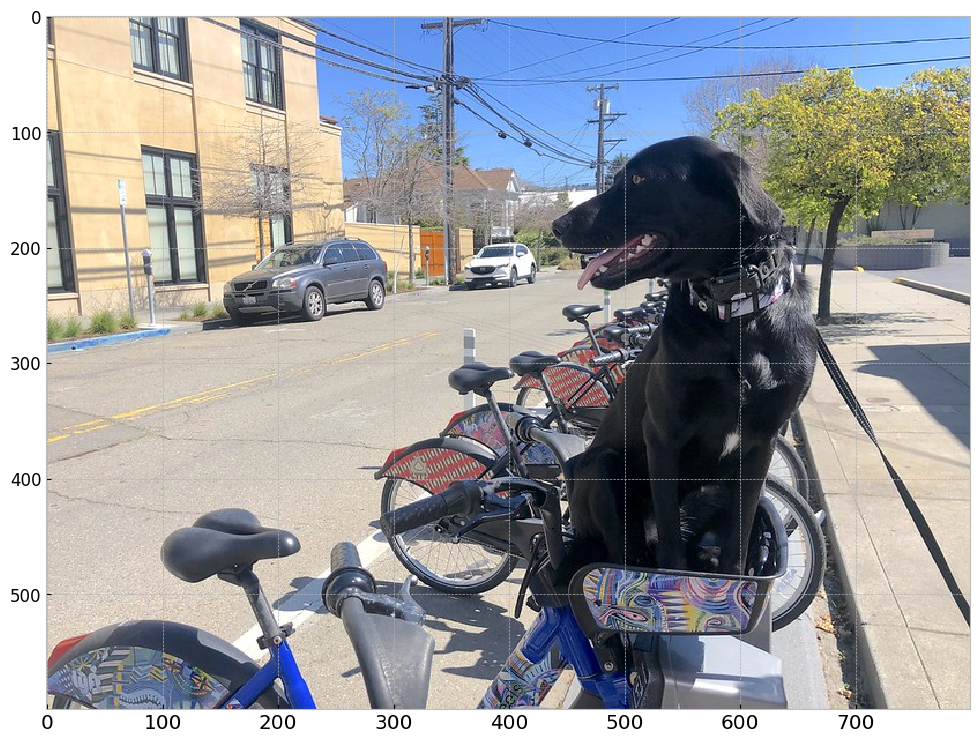

In [40]:
# The MobileNet network expects images in RGB format.
image = cv2.cvtColor(cv2.imread(filename=os.path.join(inpDir, '/home/dhpcsap/Desktop/AI/day_05/day_13/data/image/coco_bike.jpg')), code=cv2.COLOR_BGR2RGB)

# Resize the image to the network input shape.
resized_image = cv2.resize(src=image, dsize=(224, 224))

# Transpose the image to the network input shape.
input_image = np.expand_dims(resized_image, 0)

plt.imshow(image);

In [41]:
result = compiled_model(input_image)[output_key]

result_index = np.argmax(result)

In [42]:
# Convert the inference result to a class name.
imagenet_classes = open(imagenetClassesPath).read().splitlines()

# The model description states that for this model, class 0 is a background.
# Therefore, a background must be added at the beginning of imagenet_classes.
imagenet_classes = ['background'] + imagenet_classes

imagenet_classes[result_index]

'n03785016 moped'

In [43]:
num_images = 1000

start = time.perf_counter()

for _ in range(num_images):
    compiled_model([input_image])

end = time.perf_counter()
time_ir = end - start

print(
    f"IR model in OpenVINO Runtime/CPU: {time_ir/num_images:.4f} "
    f"seconds per image, FPS: {num_images/time_ir:.2f}"
)

IR model in OpenVINO Runtime/CPU: 0.0023 seconds per image, FPS: 429.61
